In [12]:
%load_ext autoreload
%autoreload 2
import sys

import pandas as pd

sys.path.append("../..")

from mlstm_kernels.utils.benchmark.plot_results import (
    plot_benchmark_result_table,
    create_runtime_bar_plot,
    rc_context_wrapper,
    select_columns,
)
from pathlib import Path
from plot_config import linestyle_mapping, style_dict
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def load_throughput_results_for_ctxes(path_template: str, ctxes: list[int]):
    results = {}
    for ctx in ctxes:
        path = Path(path_template.format(ctx=ctx))
        df = pd.read_csv(path).filter(regex=".*(batch_size|prefill|R--).*")
        results[ctx] = df
    return results

In [22]:
llama_results = load_throughput_results_for_ctxes(
    path_template="/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-06_12-48-14__throughput__forward_llama_v0/hf_7B_throughput__pfl{ctx}_gl0_tcTrue_weightdtypebfloat16/results.csv",
    ctxes=[2048, 4096, 8192],
)

mamba_results = load_throughput_results_for_ctxes(
    path_template="/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-06_13-02-27__throughput__forward_mamba_v2/hf_7B_throughput__pfl{ctx}_gl0_tcTrue_weightdtypebfloat16/results.csv",
    ctxes=[2048, 4096, 8192],
)

mxlstm_results = load_throughput_results_for_ctxes(
    path_template="/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-06_12-46-45__throughput__forward_xlstm_v0/hf_7B_throughput__pfl{ctx}_gl0_tcTrue_weightdtypebfloat16/results.csv",
    ctxes=[2048, 4096, 8192],
)

In [23]:
mamba_results[8192]

,P--prefill_length,P--batch_size,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False
0,8192,1,288.177475,452.478966
1,8192,4,1182.935242,2009.936493
2,8192,8,2395.814148,3984.311279


In [36]:
# collect all results sorted by context
result_dicts = [
    llama_results,
    mamba_results,
    mxlstm_results,
]
combined_raw_data = {}
for ctx in [2048, 4096, 8192]:
    ctx_df = pd.concat([rd[ctx] for rd in result_dicts], axis=1)
    # select batch size only once
    ctx_df = pd.concat(
        [
            ctx_df.filter(regex="batch_size").take([0], axis=1),
            ctx_df.filter(regex="prefill").take([0], axis=1),
            ctx_df.filter(regex=".*R--.*"),
        ],
        axis=1,
    )
    combined_raw_data[ctx] = ctx_df

In [37]:
with open("throughput_data.p", "wb") as f:
    pickle.dump(combined_raw_data, f)

for k, v in combined_raw_data.items():
    v.to_csv(f"raw_data_throughput_{k}.csv")

In [39]:
def compute_throughput_tokens_per_sec(raw_data_dict: dict[str, pd.DataFrame]):
    throughput_dict = {}
    for ctx, df in raw_data_dict.items():
        batch_size_col = df.filter(regex="batch_size").take([0], axis=1)
        prefill_col = df.filter(regex="prefill").take([0], axis=1)
        tokens_per_sec_df = (
            ctx * batch_size_col.values / (df.filter(regex=".*R--.*") / 1000)
        )
        throughput_dict[ctx] = pd.concat(
            [batch_size_col, prefill_col, tokens_per_sec_df], axis=1
        )
    return throughput_dict

In [40]:
throughput_data = compute_throughput_tokens_per_sec(combined_raw_data)

In [41]:
throughput_data[2048]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
0,1,2048,41115.706856,37273.533968,28160.046057,18219.315224,45366.864888
1,4,2048,43497.752471,37545.813637,28223.737891,16793.816425,46438.265959
2,8,2048,43491.235391,38592.246352,28114.549562,16778.117562,47391.693553
3,16,2048,43187.572567,38413.077038,27660.125046,16938.767377,47879.744963
4,32,2048,42717.103109,37931.575827,27271.647745,16878.320303,47580.028067
5,64,2048,NaN,37369.814764,NaN,NaN,NaN
6,128,2048,NaN,NaN,NaN,NaN,NaN


In [42]:
throughput_data[4096]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
0,1,4096,41686.960745,37335.107490,28590.497929,18886.093571,46417.329706
1,4,4096,42325.697371,37305.855169,27911.938548,16829.880641,47279.327491
2,8,4096,41961.561276,36835.925296,27585.127620,16873.206088,47952.123878
3,16,4096,41130.517078,36593.256054,27183.777762,16839.658242,47542.531585
4,32,4096,NaN,36158.822612,NaN,NaN,NaN
5,64,4096,NaN,NaN,NaN,NaN,NaN
6,128,4096,NaN,NaN,NaN,NaN,NaN


In [43]:
throughput_data[8192]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
0,1.0,8192.0,37095.314853,33220.823816,28426.926847,18104.708992,46283.343723
1,4.0,8192.0,37808.870418,34090.926774,27700.586511,16303.002665,47957.827341
2,8.0,8192.0,37965.532091,33939.704388,27354.375570,16448.514036,47627.074616
3,16.0,8192.0,NaN,33659.370874,NaN,NaN,NaN
4,32.0,8192.0,NaN,NaN,NaN,NaN,NaN
5,64.0,8192.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
throughput_8192 = throughput_data[8192].loc[
    throughput_data[8192]["P--batch_size"] == 8.0
]

In [45]:
throughput_4096 = throughput_data[4096].loc[
    throughput_data[4096]["P--batch_size"] == 16.0
]

In [46]:
throughput_2048 = throughput_data[2048].loc[
    throughput_data[2048]["P--batch_size"] == 32.0
]

In [48]:
throughput_df = pd.concat([throughput_2048, throughput_4096, throughput_8192])

In [49]:
throughput_df

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
4,32.0,2048.0,42717.103109,37931.575827,27271.647745,16878.320303,47580.028067
3,16.0,4096.0,41130.517078,36593.256054,27183.777762,16839.658242,47542.531585
2,8.0,8192.0,37965.532091,33939.704388,27354.375570,16448.514036,47627.074616


## Plotting the raw data

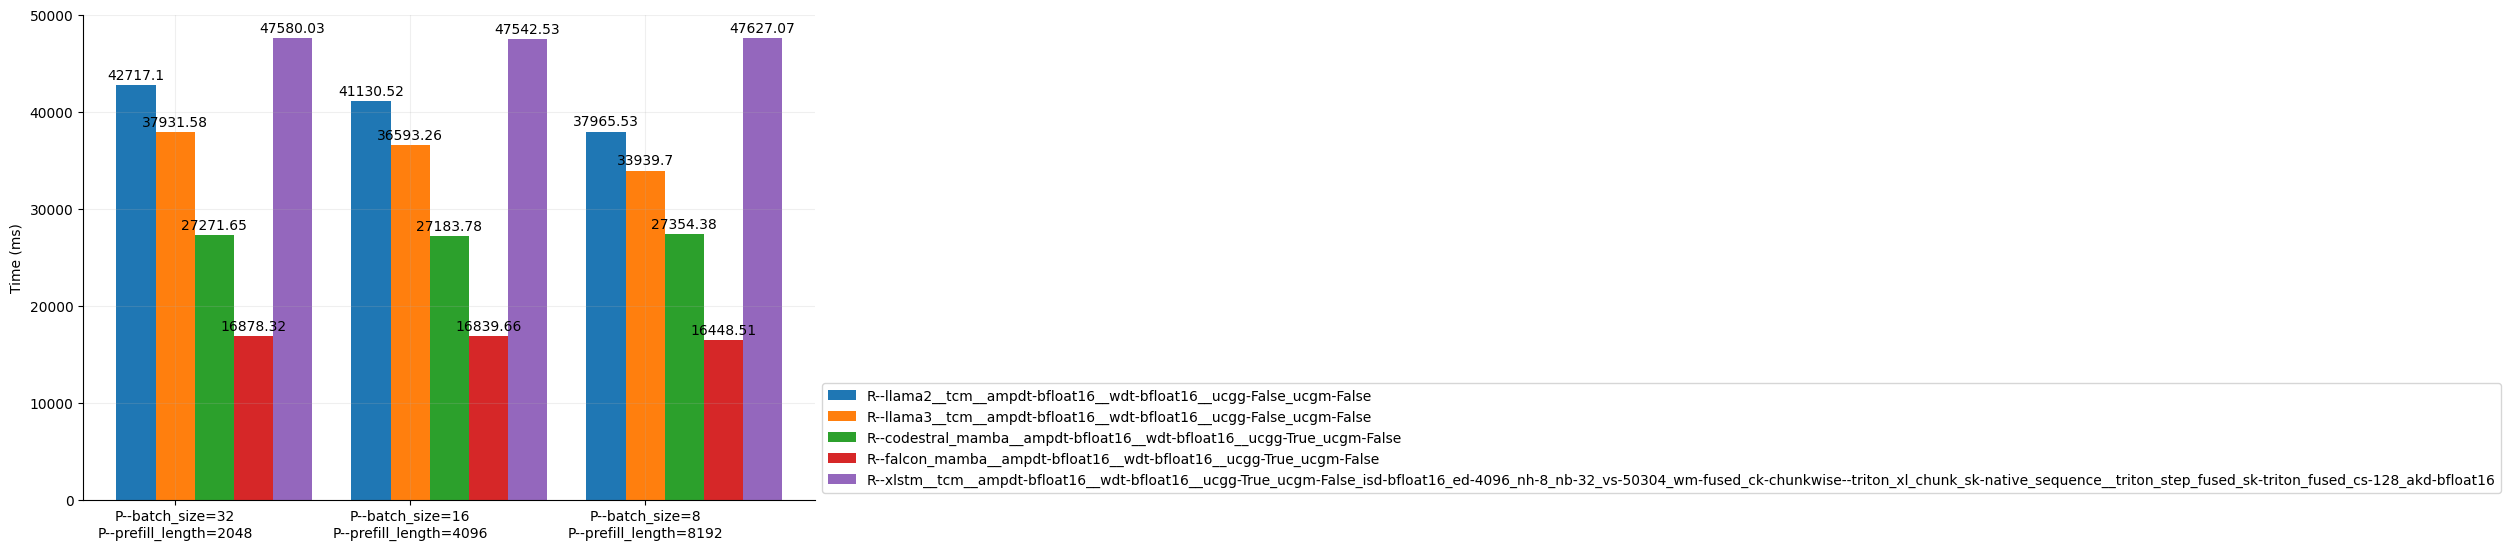

In [ ]:
fig = create_runtime_bar_plot(
    data_df=throughput_df,
    group_col_names=["P--batch_size", "P--prefill_length"],
)

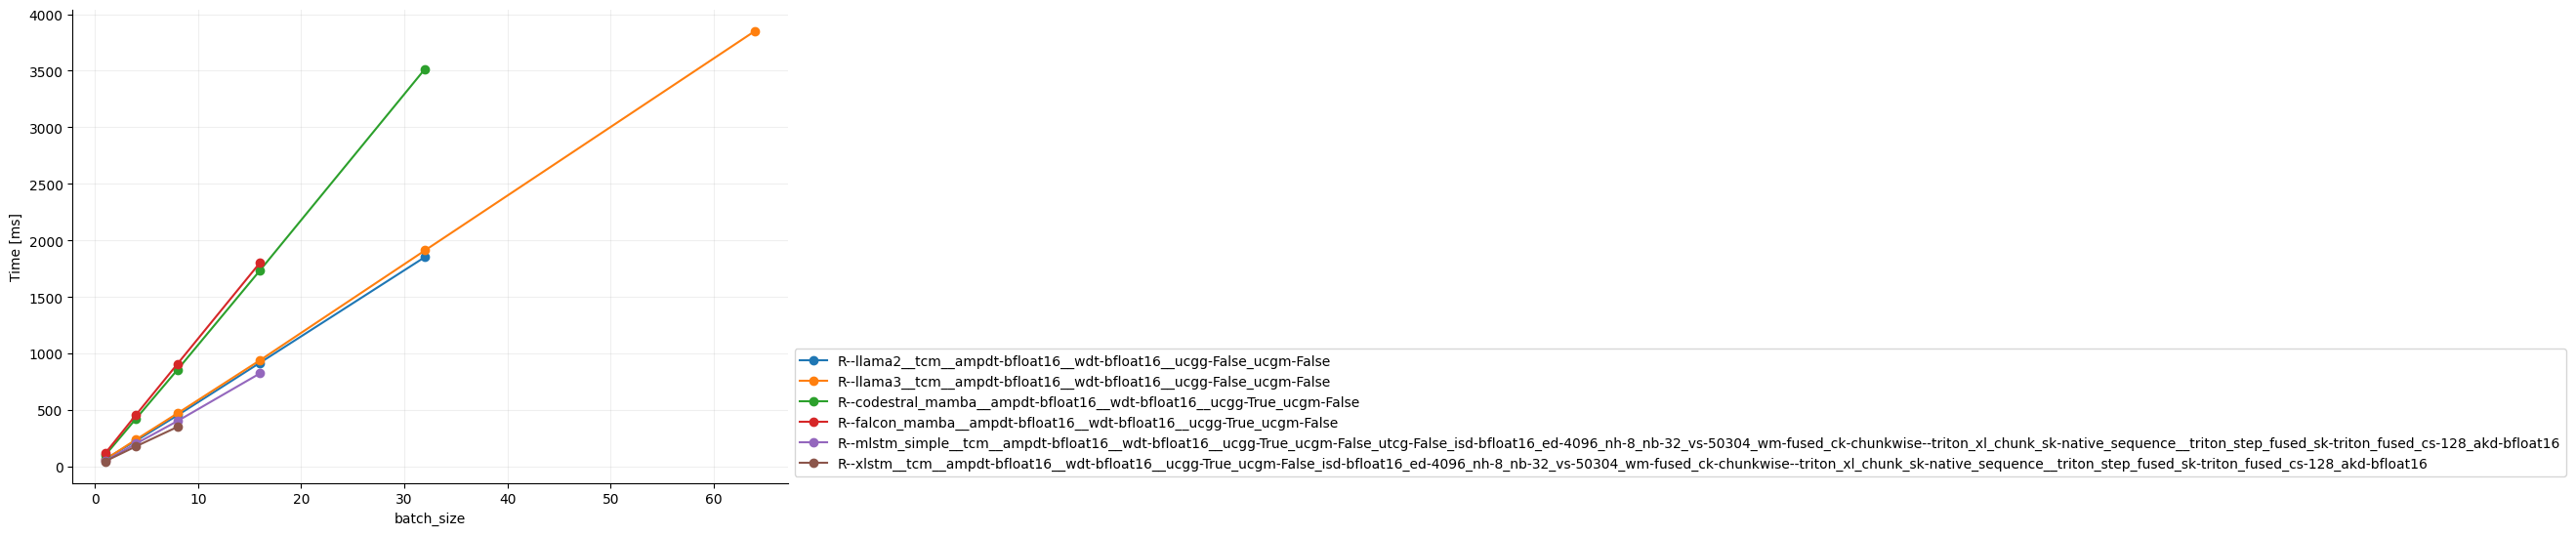

In [ ]:
fig = plot_benchmark_result_table(
    combined_raw_data[2048],
    x_axis_param="batch_size",
    # linestyle_mapping=linestyle_mapping,
    # style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Time [ms]",
    title="",
)

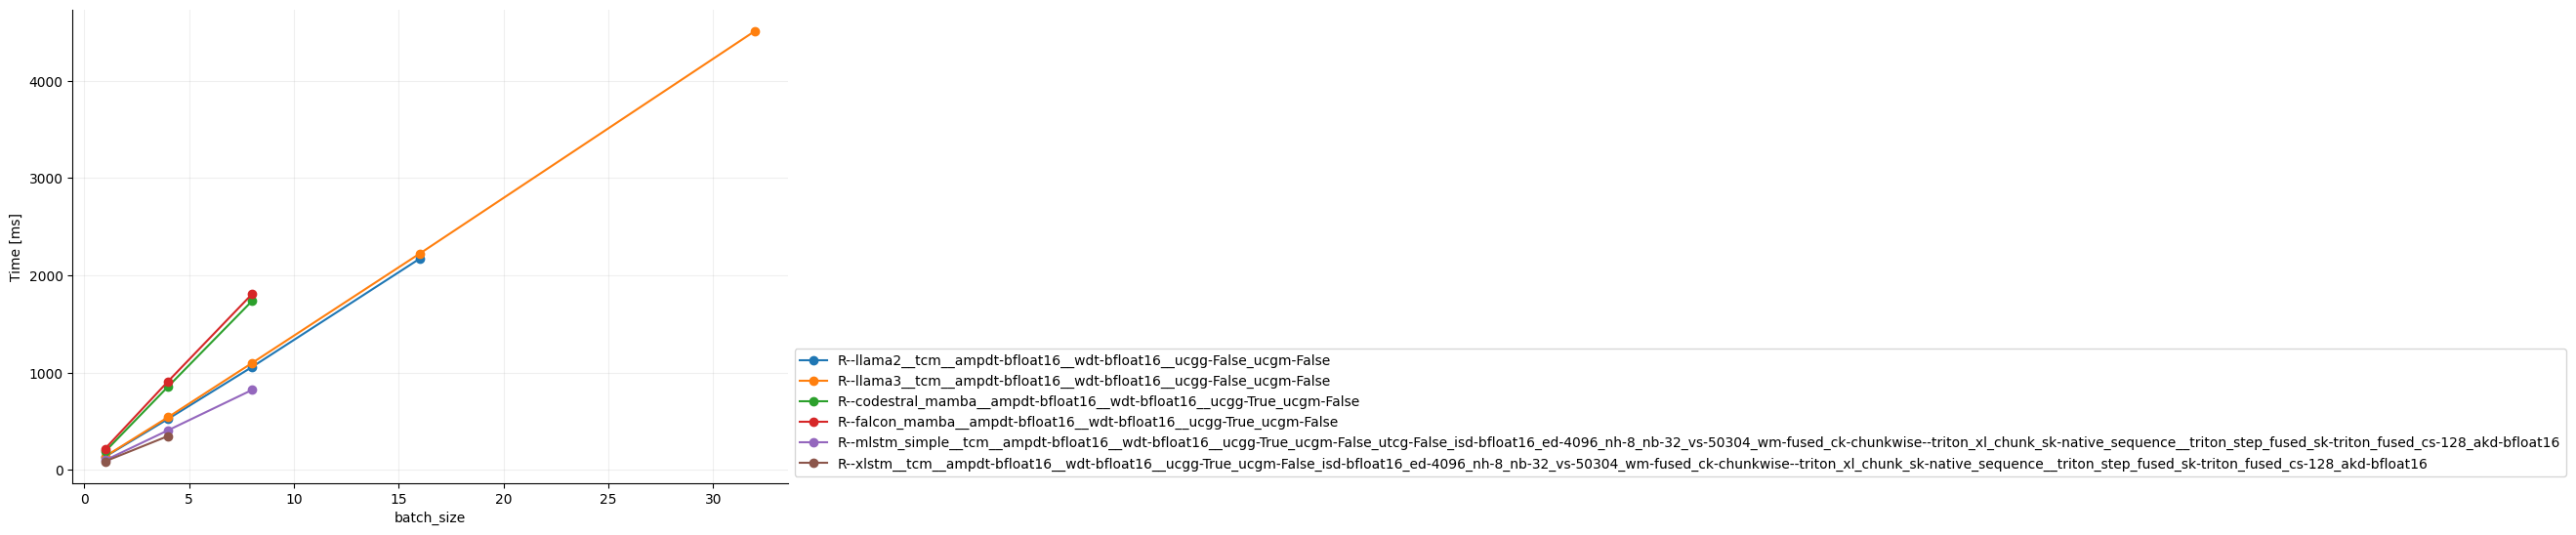

In [ ]:
fig = plot_benchmark_result_table(
    combined_raw_data[4096],
    x_axis_param="batch_size",
    # linestyle_mapping=linestyle_mapping,
    # style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Time [ms]",
    title="",
)

In [ ]:
fig = plot_benchmark_result_table(
    gen_mem_df,
    x_axis_param="generation_length",
    # linestyle_mapping=linestyle_mapping,
    # style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Memory GB",
    title="Time to generate X tokens, no prefill",
)

## Final Plots - All results

In [ ]:
selected_columns_runtime = {
    "llama3": "R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False",
    "llama2": "R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False",
    "falcon_mamba": "R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-True",
    "codestral_mamba": "R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-True",
    "xlstm": "R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-True_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16",
}
selected_columns_memory = {
    "llama2": "M--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False",
    "llama3": "M--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False",
    "falcon_mamba": "M--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-True",
    "codestral_mamba": "M--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-True",
    "xlstm": "M--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-True_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16",
}
filename_suffix = ""
add_legend = True

In [ ]:
gen_time_plot_df = select_columns(
    gen_time_df, selected_columns_runtime, keep_col_regex=".*generation.*"
)

In [ ]:
fig = rc_context_wrapper(
    func=plot_benchmark_result_table,
    result_df=gen_time_plot_df,
    x_axis_param="generation_length",
    # linestyle_mapping=linestyle_mapping,
    style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Generation Time [s]",
    x_label="Generated Tokens",
    title="",  # "Time to generate 1 tokens, for varying prefill lengths",
    figsize=(1.5 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
    filename=f"generation_time{filename_suffix}",
    add_legend=add_legend,
)

In [ ]:
gen_mem_plot_df = select_columns(
    gen_mem_df, selected_columns_memory, keep_col_regex=".*generation.*"
)

In [ ]:
fig = rc_context_wrapper(
    func=plot_benchmark_result_table,
    result_df=gen_mem_plot_df,
    x_axis_param="generation_length",
    # linestyle_mapping=linestyle_mapping,
    style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="GPU Memory [GB]",
    x_label="Generation Length",
    title="",  # "Time to generate 100 tokens, for varying prefill lengths",
    figsize=(1.5 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
    filename=f"generation_memory{filename_suffix}",
    add_legend=add_legend,
)